/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/200], Train Loss: 0.9719, Train Accuracy: 0.6099, Test Accuracy: 0.7903
Epoch [2/200], Train Loss: 0.4416, Train Accuracy: 0.8229, Test Accuracy: 0.8456
Epoch [3/200], Train Loss: 0.3558, Train Accuracy: 0.8642, Test Accuracy: 0.8364
Epoch [4/200], Train Loss: 0.3149, Train Accuracy: 0.8762, Test Accuracy: 0.8777
Epoch [5/200], Train Loss: 0.2775, Train Accuracy: 0.8949, Test Accuracy: 0.8898
Epoch [6/200], Train Loss: 0.2438, Train Accuracy: 0.8999, Test Accuracy: 0.9107
Epoch [7/200], Train Loss: 0.2290, Train Accuracy: 0.9101, Test Accuracy: 0.9063
Epoch [8/200], Train Loss: 0.2234, Train Accuracy: 0.9115, Test Accuracy: 0.9092
Epoch [9/200], Train Loss: 0.2027, Train Accuracy: 0.9211, Test Accuracy: 0.9146
Epoch [10/200], Train Loss: 0.1913, Train Accuracy: 0.9224, Test Accuracy: 0.9194
Epoch [11/200], Train Loss: 0.1766, Train Accuracy: 0.9307, Test Accuracy: 0.9218
Epoch [12/200], Train Loss: 0.1913, Train Accuracy: 0.9241, Test Accuracy: 0.9180
Epoch [13/200], Train Los

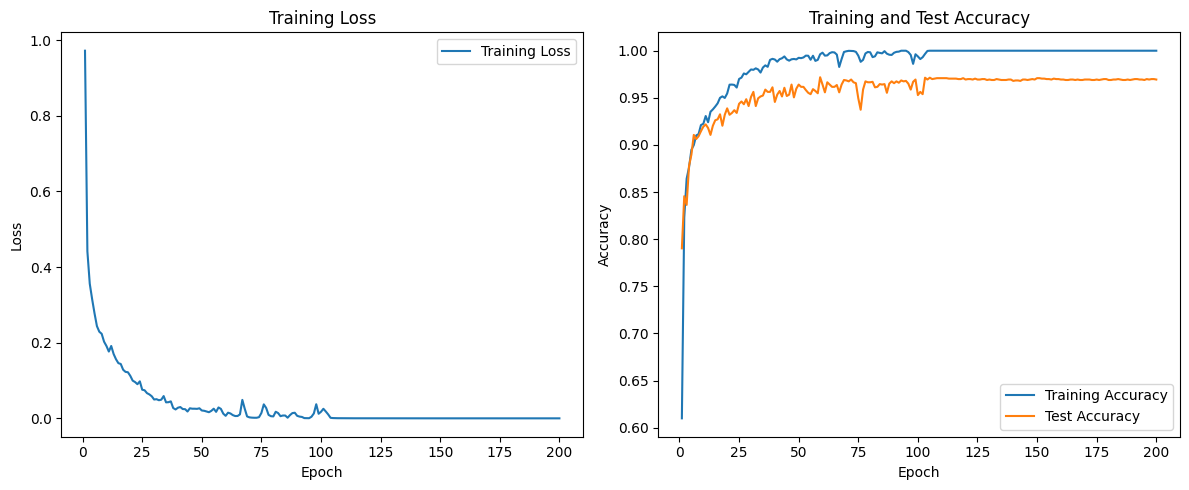

In [15]:
import matplotlib.pyplot as plt


import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

label_encoder = LabelEncoder()
y_combined_encoded = label_encoder.fit_transform(y)

X_tensor = torch.FloatTensor(X_temparr)
y_tensor = torch.LongTensor(y_combined_encoded)

device = torch.device("cpu")
X_tensor, y_tensor = X_tensor.to(device), y_tensor.to(device)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class HybridModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(HybridModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=hidden_size, batch_first=True, dropout=0.5)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x.unsqueeze(1)))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

model1 = HybridModel(input_size=20, hidden_size=64, num_classes=len(label_encoder.classes_)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
# Lists to store training loss, training accuracy, and test accuracy
train_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 200
for epoch in range(num_epochs):
    model1.train()
    total_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()

    train_epoch_loss = total_loss / len(train_loader)
    train_epoch_accuracy = correct_train_predictions / total_train_samples

    # Store training loss and accuracy
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)

    model1.eval()
    correct_test_predictions = 0
    total_test_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model1(inputs)
            _, preds = torch.max(outputs, 1)
            total_test_samples += labels.size(0)
            correct_test_predictions += (preds == labels).sum().item()

    test_epoch_accuracy = correct_test_predictions / total_test_samples

    # Store test accuracy
    test_accuracies.append(test_epoch_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f}, "
          f"Test Accuracy: {test_epoch_accuracy:.4f}")

# Plotting
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


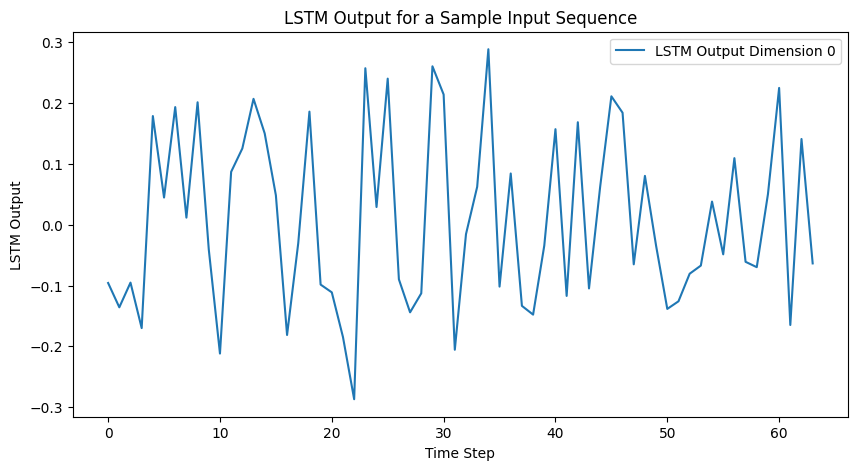

In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# Choose a sample input sequence from the test dataset
sample_input, sample_label = next(iter(test_loader))
sample_input = sample_input.to(device)

# Set the model to evaluation mode
model.eval()

# Pass the sample input through the model
with torch.no_grad():
    # Get the output of the LSTM layer
    lstm_output, _ = model.lstm1(sample_input.unsqueeze(1))
    # Flatten the output for plotting
    lstm_output = lstm_output.view(lstm_output.size(0), -1)

# Choose a dimension to plot (e.g., the first dimension)
dimension_to_plot = 0
lstm_output_to_plot = lstm_output[:, dimension_to_plot].cpu().numpy()

# Plot the LSTM output
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(lstm_output_to_plot)), lstm_output_to_plot, label=f'LSTM Output Dimension {dimension_to_plot}')
plt.xlabel('Time Step')
plt.ylabel('LSTM Output')
plt.title('LSTM Output for a Sample Input Sequence')
plt.legend()
plt.show()



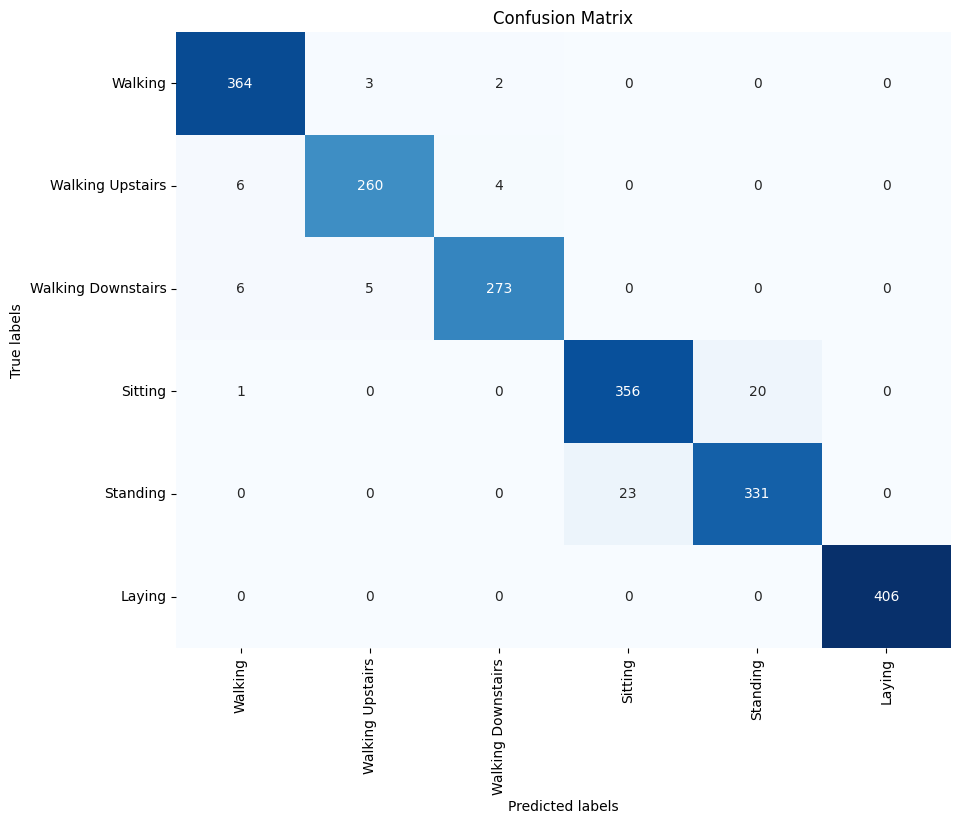

In [21]:
# Mapping activity names to label numbers
activity_names = ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']

# Adjust the labels to start from 0
adjusted_all_labels = [label - 1 for label in all_labels]
adjusted_all_preds = [pred - 1 for pred in all_preds]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(adjusted_all_labels, adjusted_all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=activity_names, yticklabels=activity_names, annot_kws={"size": 10})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Rotate the x-axis tick labels vertically
plt.xticks(rotation=90)

plt.show()
